In [1]:
import pandas as pd
import nltk
import random
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.corpus import brown
from nltk.stem import PorterStemmer
import string
import re
from wordcloud import WordCloud 
import matplotlib.pyplot as plt 
import seaborn as sns
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.metrics import accuracy_score,confusion_matrix
from tensorflow.keras.preprocessing.text import one_hot

nltk.download('punkt')
nltk.download('words')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 30

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\agnes\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\agnes\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\agnes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\agnes\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\agnes\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


## Import Data

In [2]:
import pandas as pd
df = pd.read_csv('SPAM text message 20170820 - Data.csv')

## EDA

**Difference in word count between ham and spam**

In [3]:
#Add column - Word count for Message
df_eda = df
df_eda["word count"] = df_eda["Message"].apply(lambda x: len(x.split()))

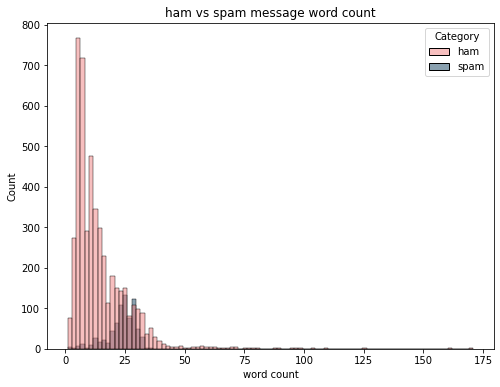

In [4]:
fig=plt.figure(figsize=(8,6))
sns.histplot(
    x=df_eda["word count"],
    hue=df_eda["Category"],
    palette=['#F08080',"#154360"]
)
plt.title("ham vs spam message word count")
plt.show()

**Tokenization & stop words removal**

In [5]:
#first, we tokenize the message
df_eda["tokenized_message"] = df_eda["Message"].apply(word_tokenize)

#then, we remove stopwords and punctuations from the tokens because they are not important in this exercise
stop_words = set(stopwords.words('english'))
df_eda['tokens_without_stopwords'] = df_eda['tokenized_message'].apply(lambda x: [w for w in x if not w.lower() in stop_words if w.isalnum()])

#afterwards, we drop the column "tokenized_message"
df_eda = df_eda.drop("tokenized_message", axis = 1)

**Check tokens diversity**

In [6]:
#Get Type-Token Ratio (TTR)
def ttr_calculator(tokens_list):
    tokens_len = len(tokens_list)
    type_len = len(set(tokens_list))
    if type_len == 0:
        ttr = 0
    else:
        ttr = type_len/tokens_len
    return ttr

#add TTR column
df_eda["TTR"] = df_eda["tokens_without_stopwords"].apply(ttr_calculator)

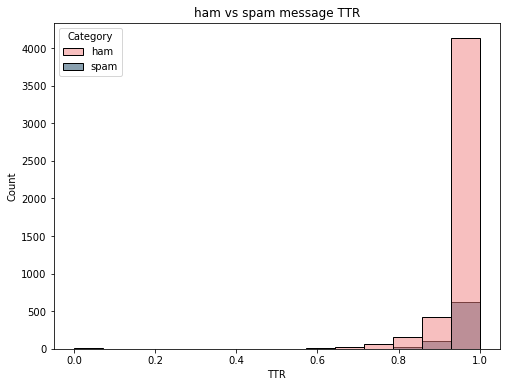

In [7]:
fig=plt.figure(figsize=(8,6))
sns.histplot(
    x=df_eda["TTR"],
    hue=df_eda["Category"],
    palette=['#F08080',"#154360"]
)
plt.title("ham vs spam message TTR")
plt.show()

**check foreign characters using regex**

In [8]:
def foreign_char_check(tokens_list):
    regex = "[^((0-9)|(a-z)|(A-Z)|\s)]"
    foreign_char = [token for token in tokens_list if bool(re.search(regex, token))]
    return foreign_char

In [9]:
#add a new column for foreign words
df_eda["foreign_words"] = df_eda["tokens_without_stopwords"].apply(foreign_char_check)
df_eda['len_foreign_words'] = df_eda["foreign_words"].apply(len)

In [10]:
df_eda[df_eda['len_foreign_words'] != 0]

,Category,Message,word count,tokens_without_stopwords,TTR,foreign_words,len_foreign_words
22,ham,So ü pay first lar... Then when is da stock comin...,11,"[ü, pay, first, lar, da, stock, comin]",1.000000,[ü],1
35,ham,Yup... Ok i go home look at the timings then i msg ü again... Xuhui going to learn on 2nd may too but her lesson is at 8am,28,"[Yup, Ok, go, home, look, timings, msg, ü, Xuhui, going, learn, 2nd, may, lesson, 8am]",1.000000,[ü],1
125,ham,Ü predict wat time ü'll finish buying?,7,"[Ü, predict, wat, time, ü, finish, buying]",1.000000,"[Ü, ü]",2
140,ham,Got c... I lazy to type... I forgot ü in lect... I saw a pouch but like not v nice...,20,"[Got, c, lazy, type, forgot, ü, lect, saw, pouch, like, v, nice]",1.000000,[ü],1
206,ham,Ü say until like dat i dun buy ericsson oso cannot oredi lar...,13,"[Ü, say, like, dat, dun, buy, ericsson, oso, oredi, lar]",1.000000,[Ü],1
...,...,...,...,...,...,...,...
5354,ham,Aiyo cos i sms ü then ü neva reply so i wait 4 ü to reply lar. I tot ü havent finish ur lab wat.,25,"[Aiyo, cos, sms, ü, ü, neva, reply, wait, 4, ü, reply, lar, tot, ü, havent, finish, ur, lab, wat]",0.789474,"[ü, ü, ü, ü]",4
5400,ham,HARD BUT TRUE: How much you show &amp; express your love to someone....that much it will hurt when they leave you or you get seperated...!鈥┾??〨ud evening...,26,"[HARD, TRUE, much, show, amp, express, love, someone, much, hurt, leave, get, seperated, 〨ud, evening]",0.933333,[〨ud],1
5407,ham,Yup he msg me: is tat yijue? Then i tot it's my group mate cos we meeting today mah... I'm askin if ü leaving earlier or wat mah cos mayb ü haf to walk v far...,36,"[Yup, msg, tat, yijue, tot, group, mate, cos, meeting, today, mah, askin, ü, leaving, earlier, wat, mah, cos, mayb, ü, haf, walk, v, far]",0.875000,"[ü, ü]",2
5473,ham,Ok lor ü reaching then message me.,7,"[Ok, lor, ü, reaching, message]",1.000000,[ü],1


In [11]:
df_eda[df_eda['len_foreign_words'] != 0][['Category', 'foreign_words']]

,Category,foreign_words
22,ham,[ü]
35,ham,[ü]
125,ham,"[Ü, ü]"
140,ham,[ü]
206,ham,[Ü]
...,...,...
5354,ham,"[ü, ü, ü, ü]"
5400,ham,[〨ud]
5407,ham,"[ü, ü]"
5473,ham,[ü]


**All messages containing foreign characters is ham**

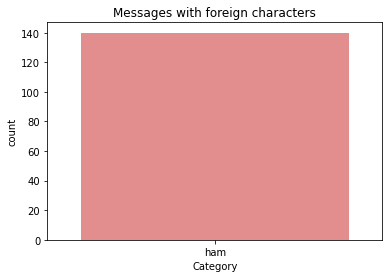

In [12]:
sns.countplot(
    data=df_eda[df_eda['len_foreign_words'] != 0],
    x="Category",
    palette=['#F08080',"#154360"]
).set(title='Messages with foreign characters')
plt.show()

#### Check the number of rows for each category

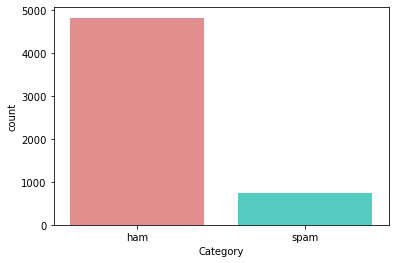

In [13]:
sns.countplot(
    data=df,
    x="Category",
    palette=['#F08080',"#40E0D0"]
)
plt.show()

The data is very imbalanced 

### Data Processing

#### First we need to balance the dataset by removing a large amount of ham data

In [14]:
random.seed(10)

#get the number of rows which need to be dropped from ham
ham_spam_difference = len(df[df.Category == 'ham'])-len(df[df.Category == 'spam'])

#get a list of ham index
ham_index = list(df[df.Category == 'ham'].index)

#randomly set the rows to be dropped
ham_index_to_drop = random.sample(ham_index, ham_spam_difference) 

In [15]:
balanced_df = df.drop(ham_index_to_drop)
balanced_df.index = range(len(balanced_df))

#### Now we can see that there are same number of rows of ham and spam data

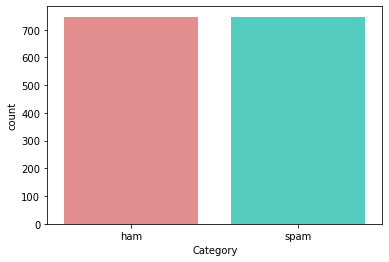

In [16]:
sns.countplot(
    data=balanced_df,
    x="Category",
    palette=['#F08080',"#40E0D0"]
)
plt.show()

**Next, we need to code ham and spam to binary labels**

In [17]:
balanced_df["Label"]=balanced_df["Category"].map({"ham":0,"spam":1})

**Text Processing**

In [18]:
#Use PorterStemmer to normalize words
stemmer=PorterStemmer()

#initialize an empty list to store words
corpus=[]

for message in balanced_df["Message"]:
    
    message=message.lower().split()
    message=[stemmer.stem(words)
            for words in message
             if words not in set(stopwords.words("english"))]
    
    #join the word lists with the whitespace
    message=" ".join(message)
    
    #append the message in corpus list
    corpus.append(message)

In [19]:
vocab_size=10000

oneHot_doc=[one_hot(words,n=vocab_size) for words in corpus]

In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
sentence_len=125
embedded_doc=pad_sequences(
    oneHot_doc,
    maxlen=sentence_len,
    padding="pre"
)

In [21]:
extract_features=pd.DataFrame(
    data=embedded_doc
)
target=balanced_df["Label"]

In [22]:
df_final=pd.concat([extract_features,target],axis=1)

In [23]:
df_final.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,111,112,113,114,115,116,117,118,119,120,121,122,123,124,Label
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6409,8687,3412,5847,7156,2421,7553,7361,6969,9245,4631,6957,3611,8175,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1795,1583,832,5700,5142,7242,4080,518,8600,9890,6100,6487,8811,778,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5059,1818,4226,421,2459,3421,5520,6290,518,1333,7978,1512,1145,3990,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4608,9084,8299,4335,7548,223,9577,1270,1752,4163,5544,4437,8939,1270,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1112,2377,6618,8989,2703,1051,6364,2703,273,2778,4124,4100,4735,5709,1


### Defin Train/Test dataset 

In [24]:
X=df_final.drop("Label",axis=1)
y=df_final["Label"]

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
  X,
  y,
  test_size=0.2
)

### Build Model

In [27]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras import callbacks

In [28]:
model=Sequential()

feature_num=100

model.add(Embedding(input_dim=vocab_size,
                    output_dim=feature_num,
                    input_length=sentence_len))
model.add(LSTM(
    units=128))

model.add(Dense(units=1,
                activation="sigmoid"))

In [29]:
model.compile(
    optimizer=Adam(
    learning_rate=0.001
    ),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

**Use Earlystopping to avoid overtraining**

In [30]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",mode ="min", patience = 5,restore_best_weights = True)

**Fit Model**

In [31]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    validation_split=0.20, 
    batch_size=16, 
    verbose=2,
    callbacks=[earlystopping]
)

Epoch 1/100
60/60 - 6s - loss: 0.4110 - accuracy: 0.8128 - val_loss: 0.2132 - val_accuracy: 0.8954 - 6s/epoch - 92ms/step
Epoch 2/100
60/60 - 3s - loss: 0.1250 - accuracy: 0.9644 - val_loss: 0.1960 - val_accuracy: 0.9331 - 3s/epoch - 55ms/step
Epoch 3/100
60/60 - 3s - loss: 0.0689 - accuracy: 0.9874 - val_loss: 0.1085 - val_accuracy: 0.9540 - 3s/epoch - 56ms/step
Epoch 4/100
60/60 - 3s - loss: 0.0281 - accuracy: 0.9927 - val_loss: 0.1023 - val_accuracy: 0.9582 - 3s/epoch - 56ms/step
Epoch 5/100
60/60 - 3s - loss: 0.0144 - accuracy: 0.9958 - val_loss: 0.1233 - val_accuracy: 0.9540 - 3s/epoch - 54ms/step
Epoch 6/100
60/60 - 3s - loss: 0.0097 - accuracy: 0.9979 - val_loss: 0.1138 - val_accuracy: 0.9623 - 3s/epoch - 56ms/step
Epoch 7/100
60/60 - 4s - loss: 0.0087 - accuracy: 0.9969 - val_loss: 0.1232 - val_accuracy: 0.9456 - 4s/epoch - 64ms/step
Epoch 8/100
60/60 - 4s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.1183 - val_accuracy: 0.9582 - 4s/epoch - 65ms/step
Epoch 9/100
60/60 - 4s -

In [32]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 0s 21ms/step - loss: 0.0795 - accuracy: 0.9766


[0.07953840494155884, 0.9765886068344116]

### Create plot for model performance metrics

In [33]:
def plot_metric(history, metric):
        train_metrics = history.history[metric]
        val_metrics = history.history['val_'+metric]
        epochs = range(1, len(train_metrics) + 1)
        plt.plot(epochs, train_metrics)
        plt.plot(epochs, val_metrics)
        plt.title('Training and validation '+ metric)
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend(["train_"+metric, 'val_'+metric])
        plt.show()

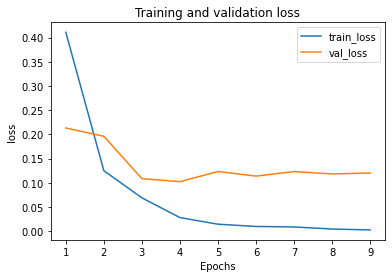

In [34]:
plot_metric(history, 'loss')

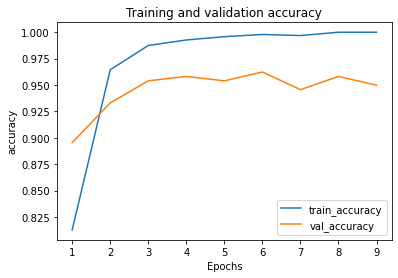

In [35]:
plot_metric(history, 'accuracy')

#### Use test dataset to get predictions

In [36]:
y_pred=model.predict(X_test)

10/10 [==============================] - 1s 23ms/step


**Loop through different threshold to see which one gives the best result**

In [37]:
max_accuracy = 0
best_threshold = 0

for threshold in np.arange(0.5, 0.99, 0.01):
    y_pred_=(y_pred>threshold)
    score=accuracy_score(y_test,y_pred_)
    if score > max_accuracy:
        max_accuracy = score
        best_threshold = threshold
    else:
        pass

print("The best accuracy {}% is achieved when the threshold is set at {}.".format(round(max_accuracy*100, 5), best_threshold))

The best accuracy 97.65886% is achieved when the threshold is set at 0.5.


**Use the best threshold to classify the predicitons**

In [38]:
y_pred=(y_pred>best_threshold)

**Confusion Matrix**

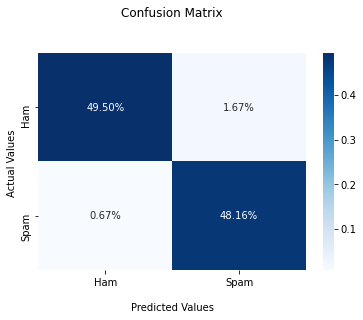

In [39]:
cf_matrix=confusion_matrix(y_test,y_pred)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Ham','Spam'])
ax.yaxis.set_ticklabels(['Ham','Spam'])

## Display the visualization of the Confusion Matrix.
plt.show()